In [2]:
%cd /data/soyeonhong/nlq/nlq_lightning
%load_ext autoreload
%autoreload 2

/data/soyeonhong/nlq/nlq_lightning


In [42]:
import json
import terminaltables
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from pathlib import Path
from pprint import pformat
from decord import VideoReader
from PIL import Image, ImageDraw
from IPython.display import Image as IPImage
from collections import Counter
from tqdm import tqdm

In [43]:
p_val_pred = Path('/data/soyeonhong/GroundVQA/VLG_OpenQA_val.json')
p_train_ann = Path('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_train.json')

p_train_pred = Path('/data/soyeonhong/GroundVQA/VLG_OpenQA_train.json')    
p_val_pred = Path('/data/soyeonhong/GroundVQA/VLG_OpenQA_val.json')
p_train_ann = Path('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_train.json')
p_val_ann = Path('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_val.json')
p_clips_dir = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official')
p_object_dir = Path('/data/soyeonhong/universal-ner/NLQ-query-uniner-extracted-object/query_uniner_outputs')
p_action_dir = Path('/data/soyeonhong/universal-ner/NLQ-query-uniner-extracted-action/query_uniner_outputs')

all_train_preds = json.loads(p_train_pred.read_text())
all_val_preds = json.loads(p_val_pred.read_text())
all_train_anns = json.loads(p_train_ann.read_text())
all_val_anns = json.loads(p_val_ann.read_text())

In [44]:
def process_predictions_and_annotations(all_preds, all_anns, p_object_dir, p_action_dir):

    quid2pred, quid2info, quid2template = {}, {}, {}
    quid2object, quid2action, quid2ann = {}, {}, {}

    # Process predictions
    for pred in all_preds:
        quid = pred['query_id']
        
        quid2pred[quid] = pred['pred_window']
        quid2info[quid] = pred['gt_window']
        
        if pred['gt_window']['template'] is not None:
            quid2template[quid] = pred['gt_window']['template']
        else:
            quid2template[quid] = 'No Template'
        
        p_object_json = p_object_dir / f'{quid}.json'
        p_action_json = p_action_dir / f'{quid}.json'
        
        obj = json.loads(p_object_json.read_text())[0]['entities']['values']
        action = json.loads(p_action_json.read_text())[0]['entities']['values']
        
        quid2object[quid] = obj
        quid2action[quid] = action

    # Process annotations
    for ann in all_anns:
        quid = ann['sample_id']
        quid2ann[quid] = ann
    
    return quid2pred, quid2info, quid2template, quid2object, quid2action, quid2ann


In [45]:
val_quid2pred, val_quid2info, val_quid2template, val_quid2object, val_quid2action, val_quid2ann = process_predictions_and_annotations(all_val_preds, all_val_anns, p_object_dir, p_action_dir)

In [46]:
train_quid2pred, train_quid2info, train_quid2template, train_quid2object, train_quid2action, train_quid2ann = process_predictions_and_annotations(all_train_preds, all_train_anns, p_object_dir, p_action_dir)

In [47]:
from collections import Counter
import pandas as pd

def get_object_counts(quid2object):
    obj_all = []

    # Collect all non-empty objects
    for key in quid2object.keys():
        for obj in quid2object[key]:
            if obj:  # Check if object is not an empty string
                obj_all.append(obj)

    # Count occurrences of each object
    obj_count = Counter(obj_all)

    # Configure pandas to display full column width
    pd.set_option('display.max_colwidth', None)

    # Create DataFrame from the object counts dictionary
    df = pd.DataFrame.from_dict(obj_count, orient='index').reset_index()
    df.columns = ['object', 'count']

    # Sort DataFrame by count in descending order
    df = df.sort_values(by='count', ascending=False)
    
    obj_set = set(obj_all)

    return df, obj_count, obj_set

train_df_obj, train_obj_count, train_obj_set = get_object_counts(train_quid2object)
val_df_obj, val_obj_count, val_obj_set = get_object_counts(val_quid2object)

In [7]:
import sys
sys.path.append('/data/soyeonhong/ego4d/EgoVLP')

from transformers import AutoTokenizer
from model.model import FrozenInTime

num_frames = 32
video_params =  {
    "model": "SpaceTimeTransformer",
    "arch_config": "base_patch16_224",
    "num_frames": num_frames,
    "pretrained": True,
    "time_init": "zeros"}
    
text_params = {
    "model": "distilbert-base-uncased",
    "pretrained": True,
    "input": "text"}

model = FrozenInTime(video_params, 
                     text_params,
                     load_checkpoint="/data/soyeonhong/ego4d/EgoVLP/pretrained/egovlp.pth")

model = model.eval()

tokenizer = AutoTokenizer.from_pretrained(text_params['model'])

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


######USING ATTENTION STYLE:  frozen-in-time
### loaded SpaceTimeTransformer model has FEWER frames than current...### loading weights, filling in the extras via zeros


/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
obj_outputs = []
with torch.no_grad():
    for obj in tqdm(list(val_obj_count.keys())):
        tokens = tokenizer(obj, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
        outputs = model.compute_text(tokens)
        obj_outputs.append(outputs)
        
obj_outputs = torch.cat(obj_outputs, dim=0)

100%|██████████| 1834/1834 [00:28<00:00, 63.93it/s]


In [ ]:
obj_dict = {}

for obj in standard_obj:
    obj_dict[obj] = []
    
with torch.no_grad():
    for not_st_obj in not_standard_obj:
        obj_token = tokenizer(not_st_obj, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
        obj_output = model.compute_text(obj_token)
        
        top_sim = None
        top_obj = None

        for st_obj in standard_obj:
            st_obj_token = tokenizer(st_obj, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
            st_obj_output = model.compute_text(st_obj_token)
            
            sim = torch.nn.functional.cosine_similarity(obj_output, st_obj_output, dim=1)
            
            if top_sim is None or sim > top_sim:
                top_sim = sim
                top_obj = st_obj
                
        print(not_st_obj, top_obj)
        obj_dict[top_obj].append(not_st_obj)
        
# save json
with open('obj_dict.json', 'w') as f:
    json.dump(obj_dict, f)

In [32]:
test_obj = not_standard_obj[0] # fire gun
test_obj_token = tokenizer(test_obj, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
test_obj_output = model.compute_text(test_obj_token)

top_sim = None
top_obj = None
with torch.no_grad():
    for obj in standard_obj:
        token = tokenizer(obj, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
        output = model.compute_text(token)
        # similarity
        sim = torch.nn.functional.cosine_similarity(test_obj_output, output)
        
        if top_sim is None or sim > top_sim:
            top_sim = sim
            top_obj = obj
        
        
print(f"Object: {top_obj}")
print(f"Similarity: {round(top_sim.item(), 3)}\n")

Object: drill
Similarity: 0.408



In [1]:
import sys

sys.path.append('/data/soyeonhong/nlq/nlq_lightning')

from model.ours.egovlp.model import TextOnlyFrozenInTime
from pathlib import Path
import random
import json
from pprint import pprint
import torch

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
model = TextOnlyFrozenInTime(ckpt_path="/data/soyeonhong/nlq/nlq_lightning/data/egovlp-config-removed.pth")
tokenizer = model.tokenizer

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
tmp = ['dog', 'cat', 'bird', 'fish', 'elephant', 'giraffe', 'lion', 'tiger', 'bear', 'wolf']

tok = tokenizer(tmp, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
feature = model(tok)

In [3]:
p_ann = Path('/data/soyeonhong/nlq/nlq_lightning/data/unified/annotations.NLQ_train_object.json')
anns = json.loads(p_ann.read_text())

idx = random.randint(0, len(anns) - 1)

p_env_root = Path('/data/soyeonhong/nlq/nlq_lightning/universal-ner/LLaVA-NeXT-Video-7B-DPO-uniner-extracted/version-1')
p_env_data = p_env_root / f'{anns[idx]["video_id"]}.json'
env_datas = json.loads(p_env_data.read_text())

ann = anns[idx]
print(f"Index: {idx}")
pprint(ann)
pprint(env_datas[0])

obj_list = []

for env_data in env_datas:
    obj_list.append(env_data['entities']['values'])

Index: 13718
{'clip_duration': 480.0663474368489,
 'clip_end_sec': 25.54104,
 'clip_start_sec': 23.65826,
 'entities': {'type': 'object', 'values': ['waste bin']},
 'moment_end_frame': 766.2312,
 'moment_start_frame': 709.7478,
 'question': 'What did I put in the waste bin?',
 'sample_id': '15656e66-3397-4870-9394-c403c09a284a_1',
 'video_id': '2a777d63-baf2-4a8d-9392-5057ce06357f'}
{'caption': 'In the image, I can see a person wearing a wristband with a '
            'digital display, likely a smartwatch or fitness tracker, and they '
            'appear to be in a domestic setting with a focus on their arm and '
            'hand. The person is indoors, and there are various elements of '
            "the room's interior design visible, such as a door, a cabinet, "
            'and a tiled floor. The person is also wearing a tattoo on their '
            "arm, and there's another person partially visible in the "
            'foreground, suggesting they might be interacting with the 

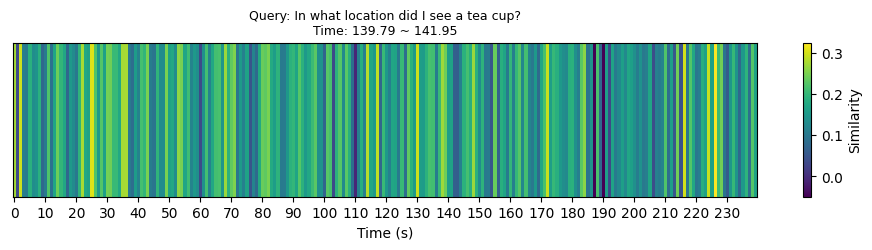

In [42]:
idx = random.randint(0, len(anns) - 1)
ann = anns[idx]
query = ann['question']
t_s = ann['clip_start_sec']
t_e = ann['clip_end_sec']
q_tok = tokenizer(query, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
q_out = model(q_tok)

cap_sim_list = []
obj_sim_list = []
with torch.no_grad():
    for env_data in env_datas:
        obj_list = env_data['entities']['values']
        cpation = env_data['caption']
        
        # print(f"Caption: {cpation}")
        # print(f"Objects: {obj_list}\n")
        # print(f"Time: {env_data['start']:.2f} ~ {env_data['end']:.2f}")
        cap_tok = tokenizer(cpation, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
        cap_out = model(cap_tok)
        obj_tok = tokenizer(obj_list, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
        obj_out = model(obj_tok)

        
        cap_sim = torch.nn.functional.cosine_similarity(q_out, cap_out)
        obj_sim = torch.nn.functional.cosine_similarity(q_out, obj_out)
        
        if obj_sim.shape[0] < 5:
            topk = obj_sim
        else:
            topk = torch.topk(obj_sim, 5).values
        
        cap_sim_list.append(cap_sim.item())
        obj_sim_list.append(topk.mean().item())
        
        # print(f"Caption similarity: {round(cap_sim.item(), 3)}")
        # print(f"Object similarity: {obj_sim.max()}\n")
        
obj_sim_list = np.array(obj_sim_list).reshape(1, -1)
plt.figure(figsize=(12, 2))
plt.imshow(obj_sim_list, aspect='auto', cmap='viridis')
plt.colorbar(label='Similarity')
plt.title(f'Query: {query}\nTime: {t_s:.2f} ~ {t_e:.2f}', fontsize=9)

plt.xticks(np.arange(0, len(obj_sim_list[0]), 10))
plt.yticks([])  # Remove y-axis ticks for a cleaner look
plt.xlabel('Time (s)')
plt.show()

In [49]:
import h5py
from model.ours.egovlp.model import TextOnlyFrozenInTime
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import json
import random 
import matplotlib.patches as patches

video_features = h5py.File("/data/soyeonhong/nlq/nlq_lightning/data/unified/egovlp_internvideo.hdf5",'r')
model = TextOnlyFrozenInTime(ckpt_path="/data/soyeonhong/nlq/nlq_lightning/data/egovlp-config-removed.pth")
tokenizer = model.tokenizer

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


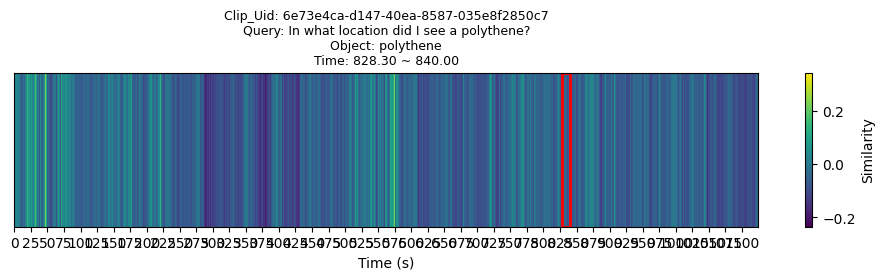

6e73e4ca-d147-40ea-8587-035e8f2850c7


In [122]:

idx = random.randint(0, len(anns) - 1)
anns = json.loads(open('/data/soyeonhong/nlq/nlq_lightning/data/unified/annotations.NLQ_val_object.json').read())
clip_uid = anns[idx]['video_id']
# clip_uid = '00d9a297-d967-4d28-8e5a-6b891814ec65'
# clip_uid = '0b20e242-a496-4662-a3e7-645bcecdbe55'
query = anns[idx]['question']
t_s = anns[idx]['clip_start_sec']
t_e = anns[idx]['clip_end_sec']
object = anns[idx]['entities']['values'][0]

data = video_features[clip_uid][:]
data_egovlp = torch.tensor(data[:,:256])

q_tok = tokenizer(query, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
q_feat = model(q_tok)
obj_tok = tokenizer(object, return_tensors='pt', padding='max_length', max_length=32, truncation=True)
obj_feat = model(obj_tok)

sim = F.cosine_similarity(q_feat, data_egovlp, dim=1)
sim_object = F.cosine_similarity(obj_feat, data_egovlp, dim=1)

plt.figure(figsize=(12, 2))
plt.imshow(sim.detach().numpy().reshape(1,-1), aspect='auto', cmap='viridis')
plt.colorbar(label='Similarity')
plt.title(f'Clip_Uid: {clip_uid}\nQuery: {query}\nObject: {object}\nTime: {t_s:.2f} ~ {t_e:.2f}', fontsize=9)

start_idx = int(t_s / 0.5)  # Convert t_s to index
end_idx = int(t_e / 0.5)    # Convert t_e to index
box_width = end_idx - start_idx      # Width of the red box

plt.xticks(np.arange(0, sim.shape[0], 50), labels = (np.arange(0, sim.shape[0], 50) * 0.5).astype(int))
plt.yticks([])  # Remove y-axis ticks for a cleaner look
plt.xlabel('Time (s)')

# Add a red rectangle with an outline and semi-transparent fill
rect = patches.Rectangle(
    (start_idx, -0.5), box_width, 1, 
    linewidth=2, edgecolor='red', facecolor='none'
)
plt.gca().add_patch(rect)

plt.show()

print(clip_uid)

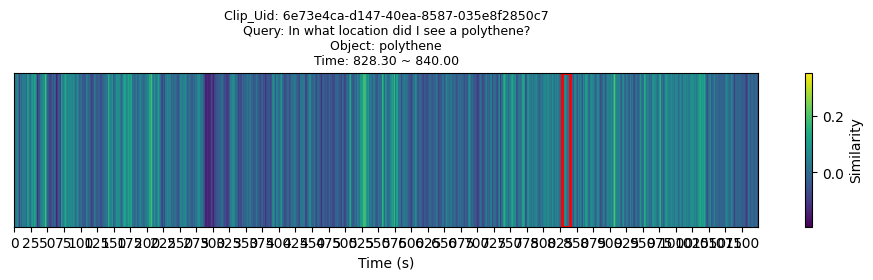

In [123]:
plt.figure(figsize=(12, 2))
plt.imshow(sim_object.detach().numpy().reshape(1,-1), aspect='auto', cmap='viridis')
plt.colorbar(label='Similarity')
plt.title(f'Clip_Uid: {clip_uid}\nQuery: {query}\nObject: {object}\nTime: {t_s:.2f} ~ {t_e:.2f}', fontsize=9)

start_idx = int(t_s / 0.5)  # Convert t_s to index
end_idx = int(t_e / 0.5)    # Convert t_e to index
box_width = end_idx - start_idx      # Width of the red box

plt.xticks(np.arange(0, sim.shape[0], 50), labels = (np.arange(0, sim.shape[0], 50) * 0.5).astype(int))
plt.yticks([])  # Remove y-axis ticks for a cleaner look
plt.xlabel('Time (s)')

# Add a red rectangle with an outline and semi-transparent fill
rect = patches.Rectangle(
    (start_idx, -0.5), box_width, 1, 
    linewidth=2, edgecolor='red', facecolor='none'
)
plt.gca().add_patch(rect)

plt.show()